# Potato Disease Classification

In [6]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [34]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
data_dir = "../data"
CHANNELS=3
EPOCHS = 50
INIT_LR = 1e-3
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


### Checking the Available Classes

In [10]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Displaying Some Sample Images

2024-10-28 14:56:39.433758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


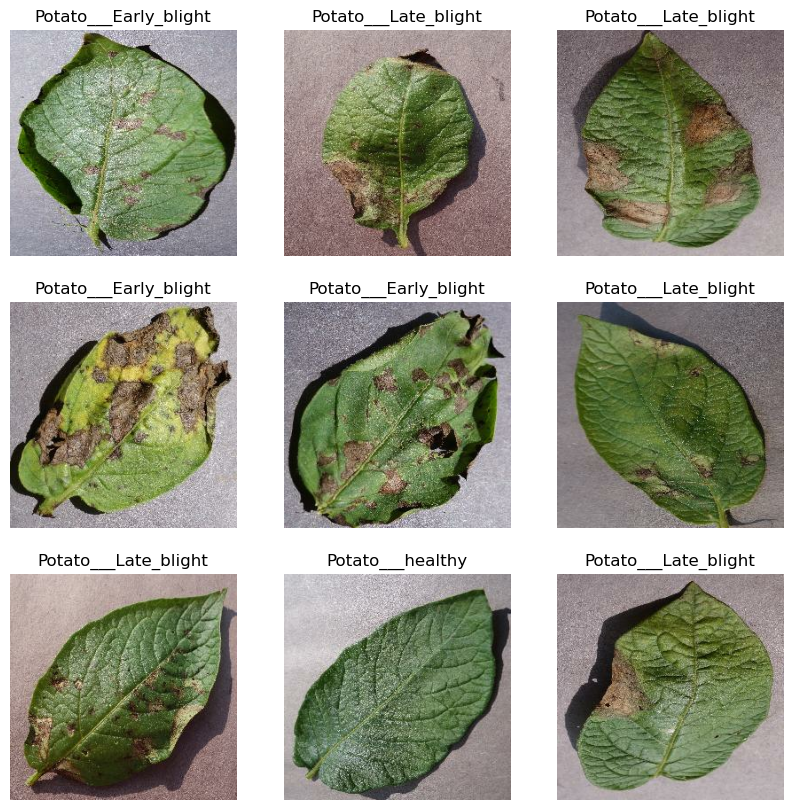

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Checking Batch Size

In [35]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

In [17]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

### Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [22]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture

In [24]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

### Compiling the Model

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 789ms/step - accuracy: 0.4773 - loss: 0.9263 - val_accuracy: 0.5990 - val_loss: 0.7724
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 881ms/step - accuracy: 0.7125 - loss: 0.6462 - val_accuracy: 0.7760 - val_loss: 0.5626
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8223 - loss: 0.4360 - val_accuracy: 0.8542 - val_loss: 0.3754
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8605 - loss: 0.3204 - val_accuracy: 0.8646 - val_loss: 0.2939
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8964 - loss: 0.2659 - val_accuracy: 0.8802 - val_loss: 0.2576
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 951ms/step - accuracy: 0.8960 - loss: 0.2560 - val_accuracy: 0.9062 - val_loss: 0.2478
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 929ms/step - accuracy: 0.9299 - loss: 0.2072 - val_accuracy: 0.9010 - val_loss: 0.2360
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 967ms/step - accuracy: 0.9324 - loss: 0.1786 - val_accuracy: 0.8

### Testing the Model

In [36]:
print("Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.9811 - loss: 0.0744
Test Accuracy: 97.66%


In [53]:
existing_versions = [int(i) for i in os.listdir("../models") if i.isdigit()]
model_version = max(existing_versions, default=0) + 1
model_dir = f"../models/{model_version}"
os.makedirs(model_dir, exist_ok=True)
model.save(f"{model_dir}/model.keras")

print(f"Model saved successfully in folder: {model_dir}")

Model saved successfully in folder: ../models/2
